# Summary of time taken and brier scores for jaxlogit, xlogit, and biogeme
Where the estimation is using draws = 600 (suboptimal but highest without running out of memory in biogeme), and training and test data is separated.

| | jaxlogit | xlogit | biogeme |
|---|---|---|---|
|Making Model | 37.7s | 16.9s | 4:15 |
|Estimating | 1.6s | 0.0s | 15.4s |
|Brier Score | 0.6345 | 0.6345 | 0.6345 |

# Setup

In [10]:
import os
os.chdir("/home/evelyn/projects_shared/jaxlogit")

import pandas as pd
import numpy as np
import jax
import pathlib
import xlogit
from time import time

from jaxlogit.mixed_logit import MixedLogit, ConfigData

import biogeme.biogeme_logging as blog
import biogeme.biogeme as bio
from biogeme import models
from biogeme.expressions import Beta, Draws, log, MonteCarlo, PanelLikelihoodTrajectory
import biogeme.database as db
from biogeme.expressions import Variable

logger = blog.get_screen_logger()
logger.setLevel(blog.INFO)

#  64bit precision
jax.config.update("jax_enable_x64", True)

os.chdir("/home/evelyn/projects_shared/jaxlogit/examples/graphs")

# Get the full electricity dataset

Use for jaxlogit and xlogit. Adjustusting n_draws can improve accuracy, but Biogeme cannot handle 700 or more draws with this data set.

In [11]:
varnames = ['pf', 'cl', 'loc', 'wk', 'tod', 'seas']
n_draws = 600
quick_draws_biogeme = [100, 200, 300, 400, 500, 600]
quick_draws_extended = [700, 800, 900, 1000, 1500, 2000, 2500, 3000, 4000, 5000]

In [12]:
rdf_fit = pd.DataFrame(columns=["package", "draws", "time"])
rdf_predict = pd.DataFrame(columns=["package", "time"])

Reshape the data so it can be passed to test_train_split in a wide format. Additionally, xlogit and jaxlogit require long format while biogeme requires a wide format.

In [13]:
df_long = pd.read_csv(pathlib.Path.cwd().parent / "electricity_long.csv")
choice_df = df_long.loc[df_long['choice'] == 1, ['id', 'chid', 'alt']]
choice_df = choice_df.rename(columns={'alt': 'choice'})
df_wide = df_long.pivot(index=['id', 'chid'], columns='alt', values=varnames)
df_wide.columns = [f'{var}_{alt}' for var, alt in df_wide.columns]
df_wide = df_wide.reset_index()
df_wide = df_wide.merge(
    choice_df,
    on=['id', 'chid'],
    how='inner',
    validate='one_to_one'
)

database_panel = db.Database('electricity', df_wide)
database_panel.panel('id')
database = db.Database('electricity', df_wide)

y = df_long['choice']
ids = df_long['chid']
alts = df_long['alt']
panels = df_long['id']

# Memory Profiling

In [14]:
from memory_profiler import memory_usage

In [15]:
df = pd.read_csv(pathlib.Path.cwd().parent / "electricity_long.csv") # get a clean version
varnames = ['pf', 'cl', 'loc', 'wk', 'tod', 'seas']
n_draws = 1000

randvars = {'pf': 'n', 'cl': 'n', 'loc': 'n', 'wk': 'n', 'tod': 'n', 'seas': 'n'}

model_jax = MixedLogit()
model_x = xlogit.MixedLogit()

init_coeff = None

X = {
    name: {
        j: Variable(f"{name}_{j}")
        for j in [1,2,3,4]
    }
    for name in varnames
}

alt_1 = Beta('alt_1', 0, None, None, 0)
alt_2 = Beta('alt_2', 0, None, None, 0)
alt_3 = Beta('alt_3', 0, None, None, 0)
alt_4 = Beta('alt_4', 0, None, None, 1)

pf_mean = Beta('pf_mean', 0, None, None, 0)
pf_sd = Beta('pf_sd', 1, None, None, 0)
cl_mean = Beta('cl_mean', 0, None, None, 0)
cl_sd = Beta('cl_sd', 1, None, None, 0)
loc_mean = Beta('loc_mean', 0, None, None, 0)
loc_sd = Beta('loc_sd', 1, None, None, 0)
wk_mean = Beta('wk_mean', 0, None, None, 0)
wk_sd = Beta('wk_sd', 1, None, None, 0)
tod_mean = Beta('tod_mean', 0, None, None, 0)
tod_sd = Beta('tod_sd', 1, None, None, 0)
seas_mean = Beta('seas_mean', 0, None, None, 0)
seas_sd = Beta('seas_sd', 1, None, None, 0)

pf_rnd = pf_mean + pf_sd * Draws('pf_rnd', 'NORMAL')
cl_rnd = cl_mean + cl_sd * Draws('cl_rnd', 'NORMAL')
loc_rnd = loc_mean + loc_sd * Draws('loc_rnd', 'NORMAL')
wk_rnd = wk_mean + wk_sd * Draws('wk_rnd', 'NORMAL')
tod_rnd = tod_mean + tod_sd * Draws('tod_rnd', 'NORMAL')
seas_rnd = seas_mean + seas_sd * Draws('seas_rnd', 'NORMAL')

choice = Variable('choice')

V = {
    j: pf_rnd * X['pf'][j] + cl_rnd * X['cl'][j] + loc_rnd * X['loc'][j] + wk_rnd * X['wk'][j] + tod_rnd * X['tod'][j] + seas_rnd * X['seas'][j]
    for j in [1,2,3,4]
}

In [19]:
combos = [('jaxlogit_scipy', "L-BFGS-B-scipy"), ('jaxlogit_scipy_b', "BFGS-scipy"), ('jaxlogit_jax', "L-BFGS-jax"),
          ('jaxlogit_optax', 'L-BFGS-optax')]
# no jax scipy batching, because it does not work.
combos_batched = [('jaxlogit_scipy_batched', "L-BFGS-scipy"), ('jaxlogit_scipy_b_batched', "BFGS-scipy")]

jaxlogit_mem = []

In [20]:
for (name, method) in combos:
    print("Doing " + str(name))
    model_jax = MixedLogit()
    config = ConfigData(
        panels=df['id'],
        n_draws=1000,
        skip_std_errs=True,  # skip standard errors to speed up the example
        batch_size=None,
        optim_method=method,
    )

    mem = memory_usage((model_jax.fit, (df[varnames], df['choice'], varnames, df['alt'], df['chid'], randvars, config)), interval=5.0, multiprocess=True)
    jaxlogit_mem.append((name, mem))

Doing jaxlogit_scipy


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Doing jaxlogit_scipy_b


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Doing jaxlogit_jax


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
**** The optimization did not converge after 44 iterations. ****
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Doing jaxlogit_optax


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [21]:
for (name, method) in combos_batched:
    model_jax = MixedLogit()
    config = ConfigData(
        panels=df['id'],
        n_draws=1000,
        skip_std_errs=True,  # skip standard errors to speed up the example
        batch_size=None,
        optim_method=method,
    )

    mem = memory_usage((model_jax.fit, (df[varnames], df['choice'], varnames, df['alt'], df['chid'], randvars, config)), interval=5.0, multiprocess=True)
    jaxlogit_mem.append((name, mem))

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Unknown optimization method: L-BFGS-scipy exiting gracefully
Optimization failed, returning None.
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


ValueError: cannot reshape array of size 4308 into shape (4308,4)

In [ ]:
# model_jax = MixedLogit()
# config = ConfigData(
#     panels=df['id'],
#     n_draws=5000,
#     skip_std_errs=True,  # skip standard errors to speed up the example
#     batch_size=None,
#     optim_method="BFGS",
# )

# mem_usage_j_l = memory_usage((model_jax.fit, (df[varnames], df['choice'], varnames, df['alt'], df['chid'], randvars, config)), interval=5.0, multiprocess=True)

In [ ]:
# model_jax = MixedLogit()
# config = ConfigData(
#     panels=df['id'],
#     n_draws=5000,
#     skip_std_errs=True,  # skip standard errors to speed up the example
#     batch_size=None,
#     optim_method="L-BFGS-optax",
# )
# mem_usage_j = memory_usage((model_jax.fit, (df[varnames], df['choice'], varnames, df['alt'], df['chid'], randvars, config)), interval=5.0, multiprocess=True)

In [22]:
# model_jax = MixedLogit()
# config = ConfigData(
#     panels=df['id'],
#     n_draws=5000,
#     skip_std_errs=True,  # skip standard errors to speed up the example
#     batch_size=1077,
#     optim_method="L-BFGS-optax",
# )
# mem_usage_medium_batch_l = memory_usage((model_jax.fit, (df[varnames], df['choice'], varnames, df['alt'], df['chid'], randvars, config)), interval=5.0, multiprocess=True)

In [23]:
# model_jax = MixedLogit()
# config = ConfigData(
#     panels=df['id'],
#     n_draws=5000,
#     skip_std_errs=True,  # skip standard errors to speed up the example
#     batch_size=1077,
#     optim_method="BFGS",
# )
# mem_usage_medium_batch = memory_usage((model_jax.fit, (df[varnames], df['choice'], varnames, df['alt'], df['chid'], randvars, config)), interval=5.0, multiprocess=True)

In [24]:
mem_usage_x = memory_usage((model_x.fit, (df[varnames], df['choice'], varnames, df['alt'], df['chid'], randvars), 
                          {"panels": df['id'], "n_draws": 5000, "skip_std_errs": True, "batch_size": None, "optim_method": "L-BFGS-B"},), interval=5.0, multiprocess=True)

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [25]:
def biogeme_running(V, choice):
    prob = models.logit(V, None, choice)
    logprob = log(MonteCarlo(PanelLikelihoodTrajectory(prob)))

    the_biogeme = bio.BIOGEME(
        database_panel, logprob, number_of_draws=600, seed=999, generate_yaml=False, generate_html=False
    )
    the_biogeme.model_name = 'model_b'
    results = the_biogeme.estimate()

mem_usage_biogeme = memory_usage((biogeme_running, (V, choice)), interval=5.0, multiprocess=True)

The number of draws (600) is low. The results may not be meaningful. 
The number of draws (600) is low. The results may not be meaningful. 
The number of draws (600) is low. The results may not be meaningful. 


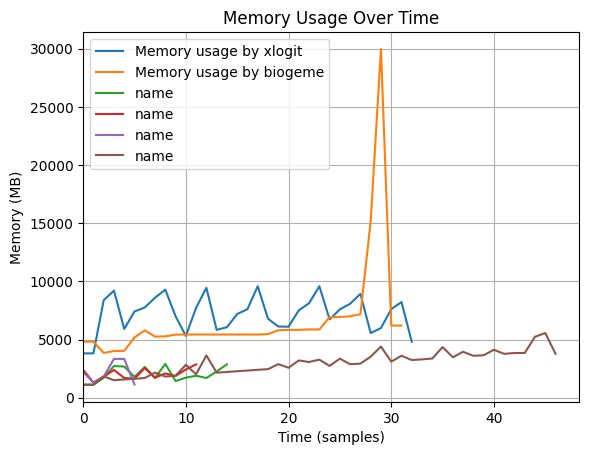

In [26]:
import matplotlib.pyplot as plt

# plt.plot(mem_usage_j, label="Memory usage by jaxlogit BFGS")
# plt.plot(mem_usage_j_l, label="Memory usage by jaxlogit L-BFGS")
plt.plot(mem_usage_x, label="Memory usage by xlogit")
# plt.plot(mem_usage_medium_batch, label="Memory usage by jaxlogit BFGS using batches")
# plt.plot(mem_usage_medium_batch_l, label="Memory usage by jaxlogit L-BFGS using batches")
plt.plot(mem_usage_biogeme, label="Memory usage by biogeme")
for (name, plot) in jaxlogit_mem:
    plt.plot(plot, label="name")
plt.xlim(left=0)
plt.xlabel("Time (samples)")
plt.ylabel("Memory (MB)")
plt.title("Memory Usage Over Time")
plt.legend()
plt.grid(True)
plt.savefig("memory_comparison")
plt.show()

# no jit usage here